In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [2]:
# twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
# twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

df = pd.read_csv('train_data.csv', delimiter="\t", header=None)
df.columns = ['id', 'label3', 'label4', 'rating', 'sub']

# NLP
# 1. To lower case
df['sub'] = df['sub'].str.lower()

# 2. Replace useless signs
df['sub'] = df['sub'].str.replace(r'[.,:()?!;$#*"\'\[\]\\]+', '', regex=True)

# 3. Strip spaces
df['sub'] = df['sub'].str.replace(r'[\s]+', ' ', regex=True)
df['sub'] = df['sub'].str.strip()

# 4. Count the number of words in review
df['words'] = [len(x.split()) for x in df['sub'].tolist()]

# 5. Replace review mark with custom classes (eg good and bad)
df['rating'] = df['rating'].apply(lambda x: 'good' if x > 0.5 else 'bad')

# Shuffle data to get independent results
df = df.sample(frac=1).reset_index(drop=True)

train_data = df[:int(len(df) * 0.9)]
test_data = df[int(len(df) * 0.9):]

twenty_train = {
  'data': train_data['sub'],
  'target': train_data['rating']
}

twenty_test = {
  'data': test_data['sub'],
  'target': test_data['rating']
}

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()


X_train_counts = count_vect.fit_transform(twenty_train['data'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# todo: reduce matrix of 
clf = MultinomialNB().fit(X_train_tfidf, twenty_train['target'])


text_clf = Pipeline([('vect', count_vect), ('tfidf', tfidf_transformer), ('clf', clf), ])
text_clf_svm = Pipeline([('vect', count_vect), ('tfidf', tfidf_transformer), ('clf-svm', SGDClassifier(n_jobs=3, loss='hinge', penalty='l2', alpha=1e-3, random_state=42)), ])

_ = text_clf_svm.fit(twenty_train['data'], twenty_train['target'])

predicted = text_clf.predict(twenty_test['data'])
predicted_svm = text_clf_svm.predict(twenty_test['data'])


np.mean(predicted == twenty_test['target']), np.mean(predicted_svm == twenty_test['target'])

(0.5668662674650699, 0.7245508982035929)

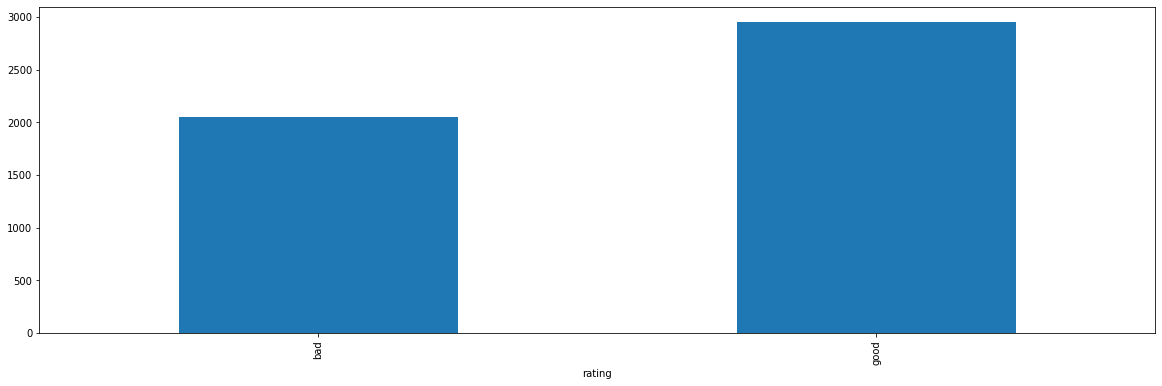

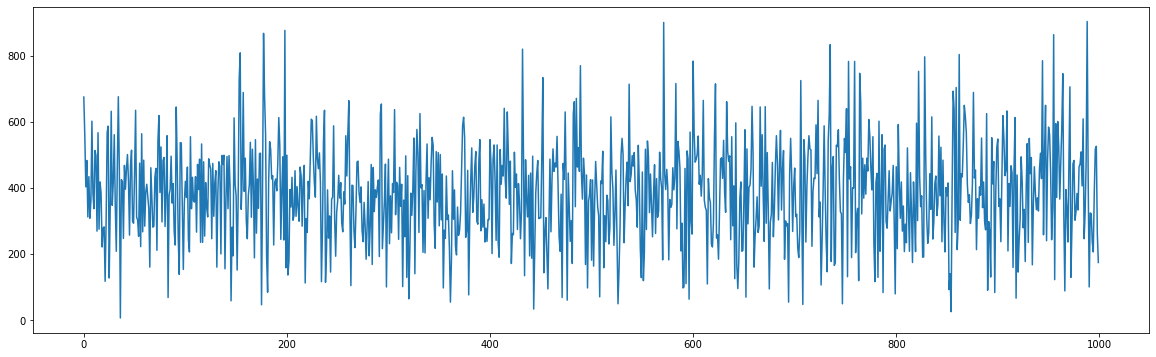

<AxesSubplot:>

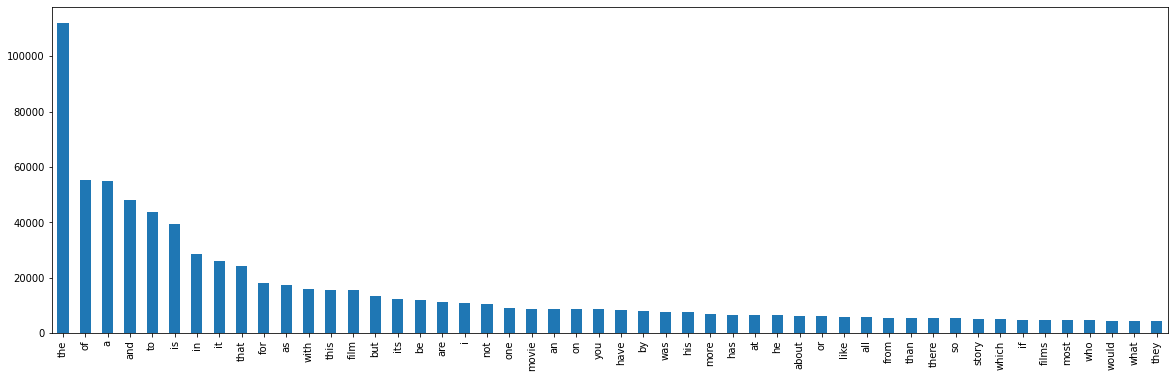

In [3]:
plt.figure(figsize=(20, 6))
df.groupby('rating').size().plot.bar(ylim=0)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(list(range(1000)), df['words'][:1000])
plt.show()

freq = df['sub'].str.split(expand=True).stack().value_counts()

plt.figure(figsize=(20, 6))
freq[:50].plot(kind='bar')